In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts,GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV,LinearRegression,BayesianRidge,Ridge, LogisticRegression
from sklearn.svm import SVR
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor as KNNR
import scipy
import plotly.plotly as py
import plotly.graph_objs as go
import pygsheets

%matplotlib inline
pd.options.display.max_rows=100
pd.options.display.max_columns=100

- Ideas
    - Bring back data
    - try cleaning it more thoroughly
    - try creating a few more interesting features (look at their distributions!!)
    - Try an MCMC or another approach
    - try PCA then a regression
- Timeline
    - do more extensive data cleaning during the week
    - convert models to DAG

In [2]:
gc = pygsheets.authorize(outh_file='/Users/irarickman/client_secret.json')
file = 'Activity data'
sh = gc.open(file)

wks_1 = sh[0]
strava=wks_1.get_as_df(empty_value=np.nan)
strava.dropna(how='all',inplace=True)

wks_2=sh[1]
whoop=wks_2.get_as_df(empty_value=np.nan)
whoop.dropna(how='all',inplace=True)
whoop.dropna(axis=1,how='all',inplace=True)

wks_3=sh[2]
acts=wks_3.get_as_df(empty_value=np.nan)
acts.dropna(how='all',inplace=True)
acts.dropna(axis=1,how='all',inplace=True)


In [3]:
print(strava.shape)
strava.columns

(272, 44)


Index(['achievement_count', 'athlete_count', 'average_speed', 'average_watts',
       'comment_count', 'commute', 'device_watts', 'distance', 'elapsed_time',
       'elev_high', 'elev_low', 'external_id', 'flagged', 'gear_id',
       'has_kudoed', 'id', 'kilojoules', 'kudos_count', 'manual', 'max_speed',
       'max_watts', 'moving_time', 'name', 'photo_count', 'private',
       'start_date', 'start_date_local', 'timezone', 'total_elevation_gain',
       'total_photo_count', 'trainer', 'type', 'upload_id',
       'weighted_average_watts', 'workout_type', 'miles', 'race',
       'date_string', 'moving_minutes', 'elapsed_minutes', 'rest', 'avg_mph',
       'time_since_last_act', 'order'],
      dtype='object')

In [4]:
strava.type.value_counts()

Run       205
Ride       38
Swim       27
Walk        1
Rowing      1
Name: type, dtype: int64

In [5]:
strava[strava.type=='Run'].describe()

,achievement_count,athlete_count,average_speed,average_watts,comment_count,distance,elapsed_time,elev_high,elev_low,gear_id,id,kilojoules,kudos_count,max_speed,max_watts,moving_time,photo_count,total_elevation_gain,total_photo_count,upload_id,weighted_average_watts,workout_type,miles,race,moving_minutes,elapsed_minutes,rest,avg_mph,time_since_last_act,order
count,205.000000,205.000000,205.000000,0.0,205.000000,205.000000,205.000000,205.000000,205.000000,0.0,2.050000e+02,0.0,205.000000,205.000000,0.0,205.000000,205.0,205.00000,205.000000,2.050000e+02,0.0,13.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,204.000000,205.000000
mean,1.180488,3.639024,3.166463,NaN,0.034146,8950.114634,3241.390244,104.105366,67.920000,NaN,1.987208e+09,NaN,3.512195,6.522927,NaN,2832.287805,0.0,76.35122,0.024390,2.123783e+09,NaN,0.692308,5.561342,0.043902,47.204797,54.023171,6.818374,7.083379,-40.710784,1.117073
std,2.431737,17.490514,0.364046,NaN,0.229673,4021.794289,1399.310238,182.827454,138.658716,NaN,2.603688e+08,NaN,2.618954,2.458999,NaN,1275.454702,0.0,76.99684,0.230919,2.707007e+08,NaN,0.480384,2.499026,0.205380,21.257578,23.321837,8.469458,0.814372,23.784742,0.337161
min,0.000000,1.000000,0.802000,NaN,0.000000,1705.200000,786.000000,-100.200000,-246.800000,NaN,1.483968e+09,NaN,0.000000,3.400000,NaN,439.000000,0.0,8.00000,0.000000,1.598846e+09,NaN,0.000000,1.059562,0.000000,7.316667,13.100000,0.000000,1.794074,-171.000000,1.000000
25%,0.000000,1.000000,3.047000,NaN,0.000000,5957.400000,2195.000000,60.000000,19.400000,NaN,1.775853e+09,NaN,2.000000,4.800000,NaN,1946.000000,0.0,40.00000,0.000000,1.906230e+09,NaN,0.000000,3.701756,0.000000,32.433333,36.583333,2.200000,6.816139,-52.000000,1.000000
50%,0.000000,1.000000,3.182000,NaN,0.000000,8632.400000,3023.000000,67.800000,46.200000,NaN,2.034058e+09,NaN,3.000000,5.800000,NaN,2710.000000,0.0,56.00000,0.000000,2.173562e+09,NaN,1.000000,5.363923,0.000000,45.166667,50.383333,3.650000,7.118134,-37.000000,1.000000
75%,1.000000,1.000000,3.322000,NaN,0.000000,10663.200000,4064.000000,90.200000,54.800000,NaN,2.207435e+09,NaN,5.000000,7.500000,NaN,3508.000000,0.0,81.00000,0.000000,2.351699e+09,NaN,1.000000,6.625803,0.000000,58.466667,67.733333,6.783333,7.431314,-25.000000,1.000000
max,13.000000,181.000000,4.304000,NaN,2.000000,22539.300000,8744.000000,1998.400000,1418.800000,NaN,2.375880e+09,NaN,17.000000,17.400000,NaN,7364.000000,0.0,611.00000,3.000000,2.526892e+09,NaN,1.000000,14.005267,1.000000,122.733333,145.733333,43.100000,9.628048,-1.000000,3.000000


2      2019-05-15 05:59:32+00:00
3      2019-05-15 06:36:58+00:00
85     2018-07-15 06:50:01+00:00
87     2018-07-15 08:57:52+00:00
144    2018-10-03 06:27:25+00:00
145    2018-10-03 07:20:42+00:00
181    2018-12-25 16:51:37+00:00
182    2018-12-26 06:40:44+00:00
188    2019-01-05 12:38:09+00:00
189    2019-01-05 13:40:22+00:00
197    2019-01-17 19:33:44+00:00
198    2019-01-18 07:59:21+00:00
203    2019-01-28 19:04:23+00:00
204    2019-01-29 06:50:47+00:00
223    2019-02-27 19:45:58+00:00
224    2019-02-28 06:39:56+00:00
227    2019-03-04 19:01:30+00:00
228    2019-03-05 07:11:27+00:00
241    2019-03-24 13:06:38+00:00
242    2019-03-24 14:10:02+00:00
247    2019-04-01 06:25:51+00:00
248    2019-04-01 06:58:36+00:00
266    2019-04-24 20:09:27+00:00
267    2019-04-25 07:38:12+00:00
Name: start_date_local, dtype: object

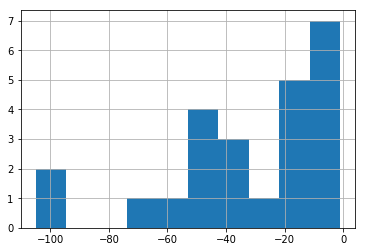

In [29]:
## since there are some times where i accidentally stored a run as two separate activities, 
## trying to find them to see if it's worth it to join them
strava['multi_act']=strava.groupby('date_string').id.transform(len)>1
strava['multi_run']=strava.groupby(['date_string','type']).id.transform(len)>1
multi_runs=strava[(strava.multi_run)&(strava.type=='Run')]
multi_runs.time_since_last_act.hist()
multi_runs['start_date_local']

In [17]:
## to simplify things, I want to delete the days with multiple activities
strava['multi_act']=strava.groupby('date_string').id.transform(len)>1
single_acts=strava[(strava.multi_act==False)&(strava.type=='Run')]
len(single_acts)

169